<a href="https://colab.research.google.com/github/JollygreenG-10/Space-Ship-Survival/blob/main/Correct_final_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Executive Summary
The pipeline for creation of a classification algorithm for the titanic spaceship dataset began with reading necessary data before performing exploratory data analysis including plotting and variable distribution summaries.  Next, NA values were counted and handled through various imputation methods.  No rows containing NA values were removed from the dataset. After handling NA values, categorical variables were dummy encoded and continuous variables were standardized to improve interpretability.  After preprocessing was complete, feature selection was performed. This process was completed using three different trials.  Two trials used wrapper methods to automatically select best features while a third method used a modified forward selection method of that which was used in class. Six final models were produced:
- Two which employed linear discriminant analysis 
- One that used quadratic discriminant analysis
- One that used a Naive Bayes classifier 
- Two logistic regression models. 

All methods used cross validation for feature selection. Overall, the best performing model was logistic regression generated using an mlxtend feature selection wrapper. This method determined a feature set of 13 variables and achieved an accuracy score of 0.796 on the held-out test set (image below marked final lr2). The best model achieved using discriminant analysis was the linear discriminant analysis model generated using an sklearn forward feature selection wrapper. This model scored 0.788 on the held-out kaggle test set.  The feature selection method used for this trial did not automatically determine the ideal number of features so half of the features were used as default (15).  Despite no direct feature number selection, the model still outperformed other discriminant analysis trials that included methods to determine the ideal feature number. Through this process, both group members collaborated on data cleaning and exploratory analysis.  Pansy completed the logistic regression model while Adam completed the discriminant analysis models. 
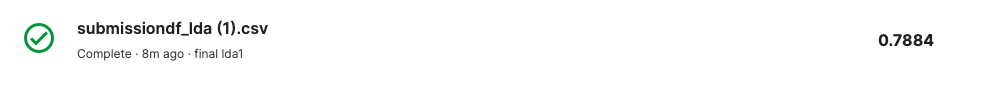

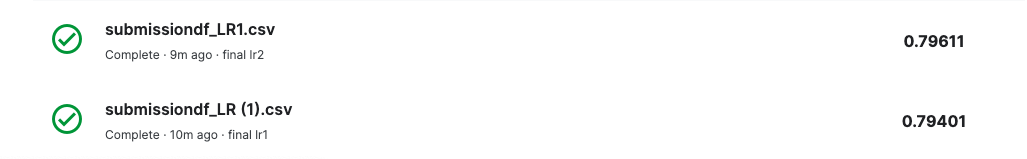

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from time import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from google.colab import files
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector as sfs
import seaborn as sns
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
!pip install mlxtend --upgrade

# 2 Detailed Report
To begin the analysis and modelling process, train and test data was first read into the notebook and merged into a single dataset for the purposes of cleaning.  Features that do not impact an individual's liklihood of being transported were removed from the dataset. These columns included PassengerId and Name.   

In [ ]:
#read and organize data for cleaning
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
id = test["PassengerId"]
labels_train = train['Transported']
train['train_code'] = 1
test['train_code'] = 0
dfs = [train, test]
full_data = pd.concat(dfs)
features = full_data.drop(['Transported', "Name"], axis = 1)
train.head()



,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,train_code
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1


##2.1 Explore the Data
After initial transformations, the next step in the analysis process was exploratory anlysis to understand the types of data present in the dataset as well as the distributions of variables.  This process included generating variable summaries as well as histograms.  This process highlighted significant right skew in most continuous predictors. In attempts to correct this skew, log and box-cox transformations were applied to skewed variables, however these transformations were unsuccessful in correcting the skew.  In the end, the variables were kept in their original form with no transformation applied.

                Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  12700.000000  12707.000000  12681.000000  12664.000000  12686.000000   
mean      28.771969    222.897852    451.961675    174.906033    308.476904   
std       14.387261    647.596664   1584.370747    590.558690   1130.279641   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       19.000000      0.000000      0.000000      0.000000      0.000000   
50%       27.000000      0.000000      0.000000      0.000000      0.000000   
75%       38.000000     49.000000     77.000000     29.000000     57.000000   
max       79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck    train_code  
count  12702.000000  12970.000000  
mean     306.789482      0.670239  
std     1180.097223      0.470144  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      1.000000  
75%       42.000000      1.000000  


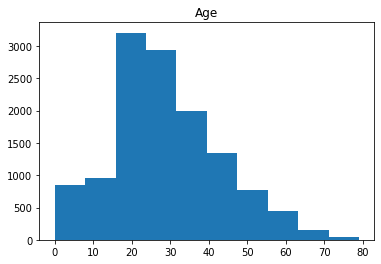

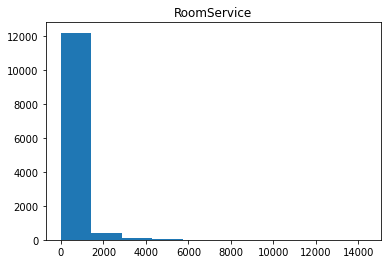

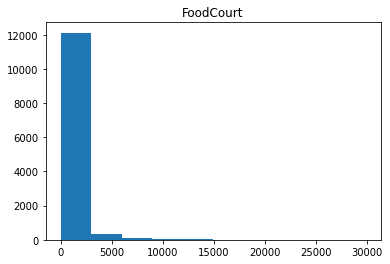

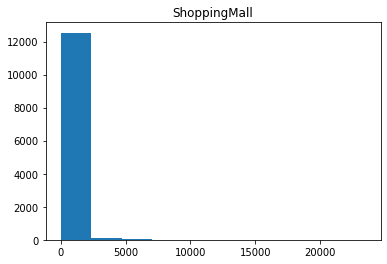

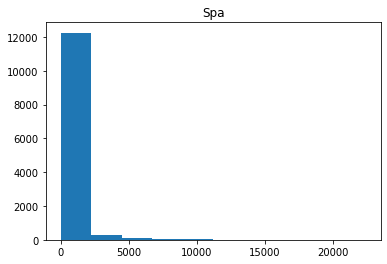

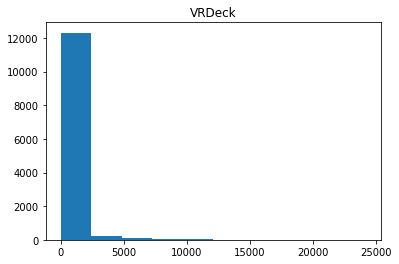

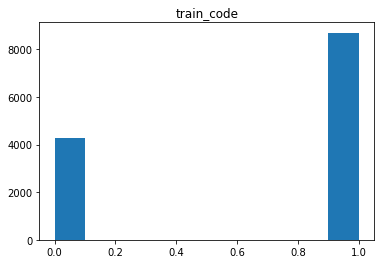

In [ ]:
#Explore data and distributions of predictors
print(features.describe())
full_data.info()
cont_cols = []
for i in features.columns:
  if full_data[i].dtype == 'int64' or full_data[i].dtype == 'float64':
    cont_cols.append(i) 
for feat in cont_cols:
  plt.hist(full_data[feat])
  plt.title(feat)
  plt.show()


##2.2 Data Cleaning
After initial EDA, data cleaning was performed to split the Cabin variable into multiple columns and NA values were counted for each column.  These NA values were then handled by either imputing zeros, imputing the most common column value or imputing the column mean.  The NA values in the VIP column were changed to false.

In [ ]:
#Count NA values and zeros
#splitting the Cabin column keeping the deck and side info and removing the cabin number
features[["Deck", "Cabin", "Side"]] = features.Cabin.str.split("/", expand = True)
print(features.head())
features.drop(["Cabin"], axis = 1, inplace = True)

#Create dictionary to denote individuals traveling with family
features[["PassengerId", "GroupCode"]] = features.PassengerId.str.split("_", expand = True)
values = features['PassengerId'].value_counts(dropna=False).keys().tolist()
counts = features['PassengerId'].value_counts(dropna=False).tolist()
value_dict = dict(zip(values, counts))
print(value_dict)

#apply dictionary to dataframe to create bernoulli column
features["pass_counts"] = features["PassengerId"].map(value_dict)
features["FamilyCounts"] = np.where(features['pass_counts'] >1, 1, 0)

features.drop(["pass_counts", "GroupCode", "PassengerId"], axis = 1, inplace = True)


  PassengerId HomePlanet CryoSleep Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False     0  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False     0  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False     0  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False     0  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False     1  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  train_code Deck Side  
0          0.0        0.0           0.0     0.0     0.0           1    B    P  
1        109.0        9.0          25.0   549.0    44.0           1    F    S  
2         43.0     3576.0           0.0  6715.0    49.0           1    A    S  
3          0.0     1283.0         371.0  3329.0   193.0           1    A    S  
4        303.0       70.0         151.0   565.0     2.0           1    F    S  
{'6499': 8, '8728': 8, '0984': 8, '4256': 8, '6986': 8, '5885': 8, '8543': 8, '8956': 8, '6332': 8,

In [ ]:
#Check for NA value in the dataset
subset = features.query("train_code == 0")

for i in subset.columns:
  na_count = subset[i].isna().sum()
  print(f"There are {na_count} NA values in {i}")
  print(f"there are {len(features[i]) - np.count_nonzero(features[i])} zeros in this column" )

features.info()

In [ ]:
#Handle NA values
zeros_list = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
common_list = ["HomePlanet", "CryoSleep", "Deck", "Side", "Destination"]

features["VIP"].fillna(False, inplace = True)
features["Age"].fillna(np.median(features["Age"].dropna()), inplace = True)

for col in zeros_list:
  features[col].fillna(0, inplace=True)
for cols in common_list:
  features[cols].fillna(features[cols].value_counts().index[0], inplace = True)

#Evaluate occurence of NA values after imputation  
print('NaN occurrences in Columns:')
print(features.isna().sum(axis = 0)) 


NaN occurrences in Columns:
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
train_code      0
Deck            0
Side            0
FamilyCounts    0
dtype: int64


### Standardization of Predictors and Dummy Encoding 
In this section, data was reverted into separate test and train datasets before a standard scaler was applied to continuous variables.  After this process, logical and categorical variables were converted to numerical columns using dummy variable encoding.  Histograms of transformed columns can be seen below. 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

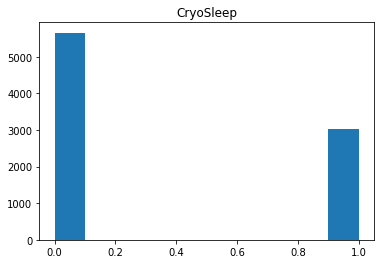

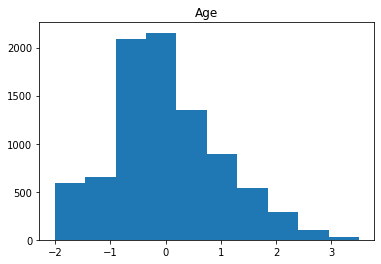

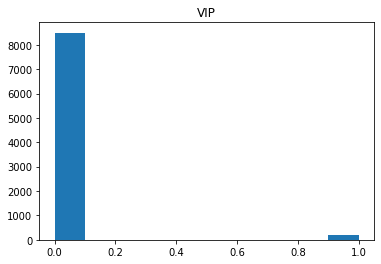

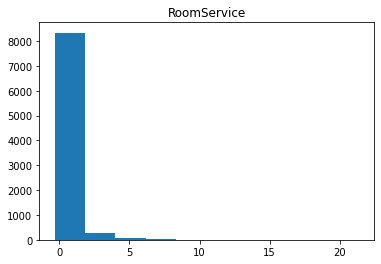

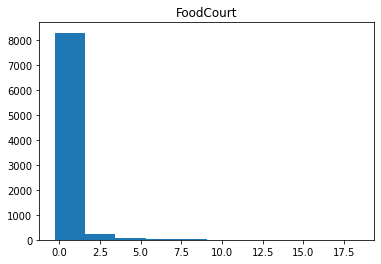

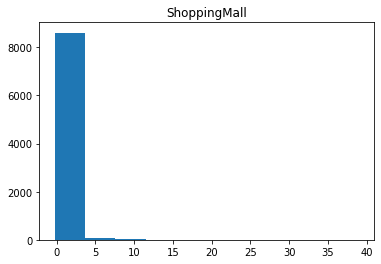

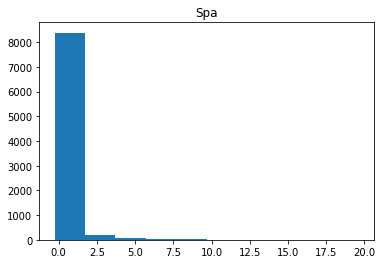

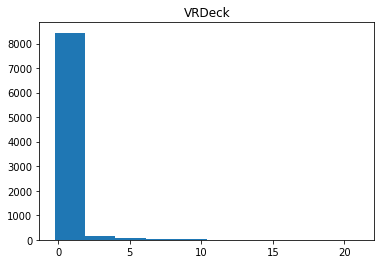

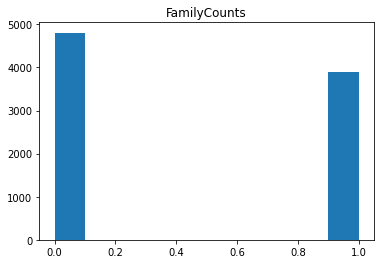

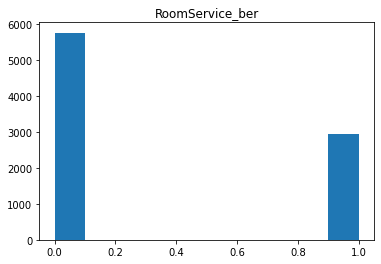

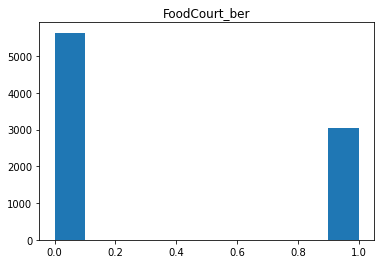

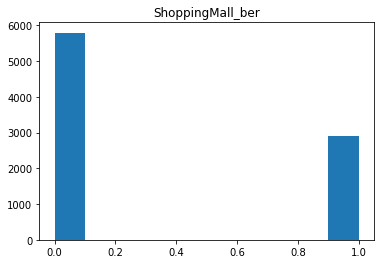

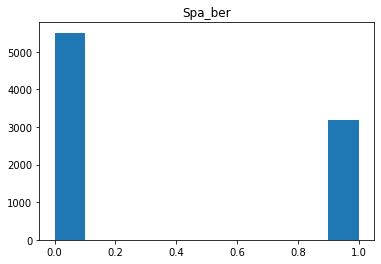

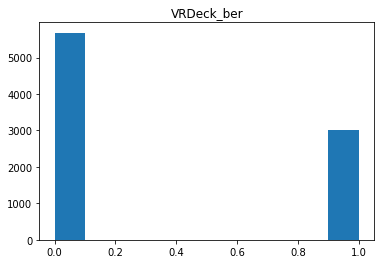

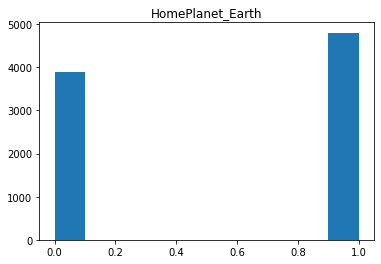

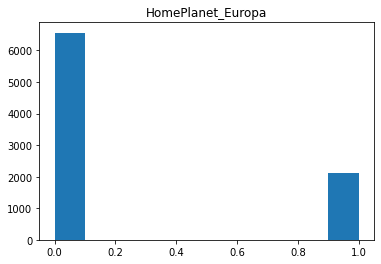

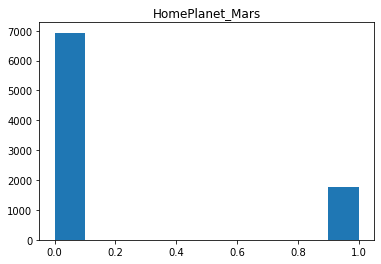

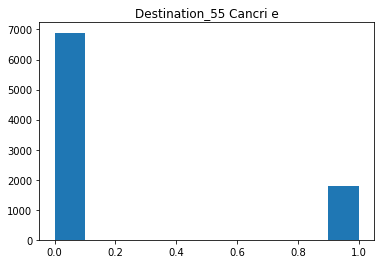

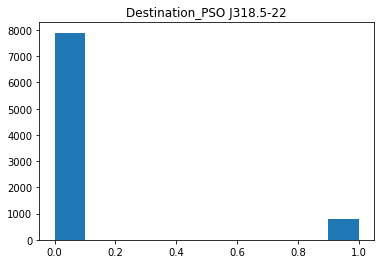

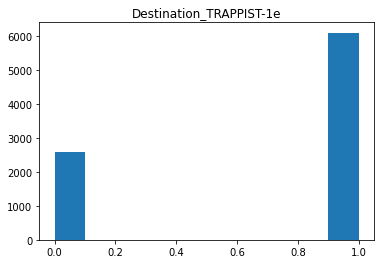

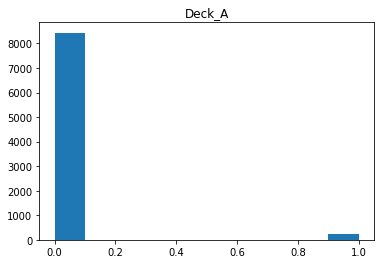

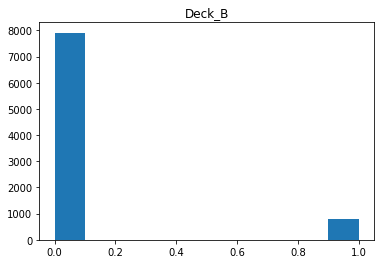

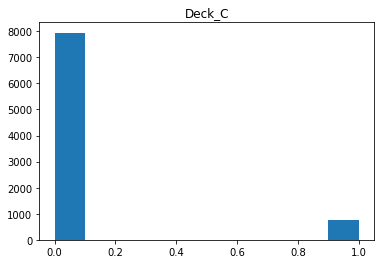

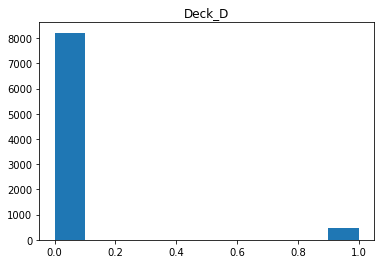

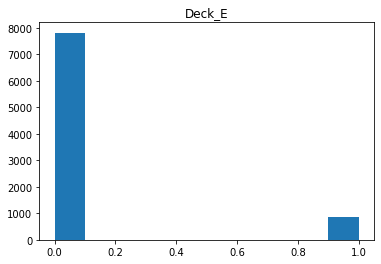

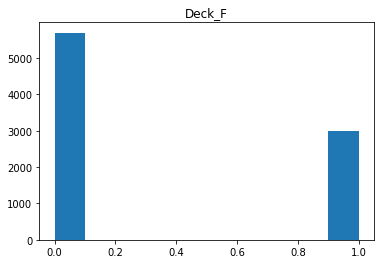

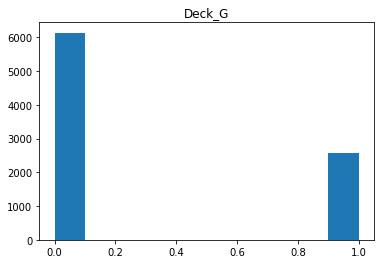

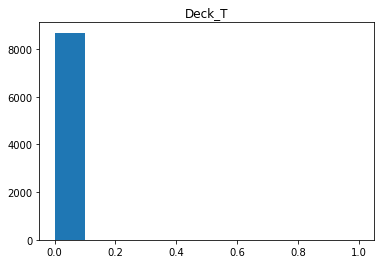

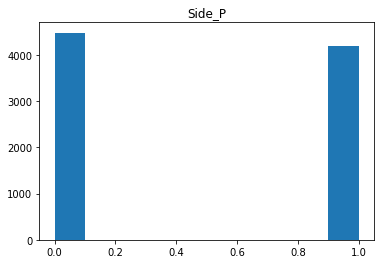

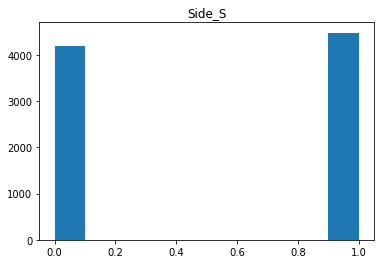

   CryoSleep       Age  VIP  RoomService  FoodCourt  ShoppingMall       Spa  \
0          0  0.711945    0    -0.333105  -0.281027     -0.283579 -0.270626   
1          0 -0.334037    0    -0.168073  -0.275387     -0.241771  0.217158   
2          0  2.036857    1    -0.268001   1.959998     -0.283579  5.695623   
3          0  0.293552    0    -0.333105   0.523010      0.336851  2.687176   
4          0 -0.891895    0     0.125652  -0.237159     -0.031059  0.231374   

     VRDeck  FamilyCounts  RoomService_ber  ...  Deck_A  Deck_B  Deck_C  \
0 -0.263003             0                0  ...       0       1       0   
1 -0.224205             0                1  ...       0       0       0   
2 -0.219796             1                1  ...       1       0       0   
3 -0.092818             1                0  ...       1       0       0   
4 -0.261240             0                1  ...       0       0       0   

   Deck_D  Deck_E  Deck_F  Deck_G  Deck_T  Side_P  Side_S  
0       0     

In [ ]:
#Standardization of continuous predictors
import statistics as stats
from sklearn.preprocessing import StandardScaler
#Split train and test 
train = features.query("train_code == 1")
train.drop(["train_code"], axis = 1, inplace = True)
test = features.query("train_code == 0")
test.drop(["train_code"], axis = 1, inplace = True)

#Create bernoulli variables to define individuals who spent money on amenities vs those who did not
def new_ber(data1, cols):
  items = []
  for col in cols:
    name = str(col) + "_ber"
    data1[name] = np.where(data1[col]>0, 1,0)

cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", 'VRDeck']
new_ber(train, cols)
new_ber(test, cols)
train.head()

SC = StandardScaler()

def scaler(data):
  continuous = []
  for col in data.columns:
    if data[col].dtype == 'float64':
      continuous.append(col)
  for entry in continuous:
    data[entry] = SC.fit_transform(data[[entry]])
  return data

train = scaler(train) 
train = pd.get_dummies(train)
test = scaler(test) 
test = pd.get_dummies(test)

#set logical columns to bernoulli distribution
train["CryoSleep"] = train["CryoSleep"].astype(int)
train["VIP"] = train["VIP"].astype(int)

test["CryoSleep"] = test["CryoSleep"].astype(int)
test["VIP"] = test["VIP"].astype(int)

#View distributions of updated data
for i in train.columns:
  plt.hist(train[i])
  plt.title(i)
  plt.show()
print(train.head())

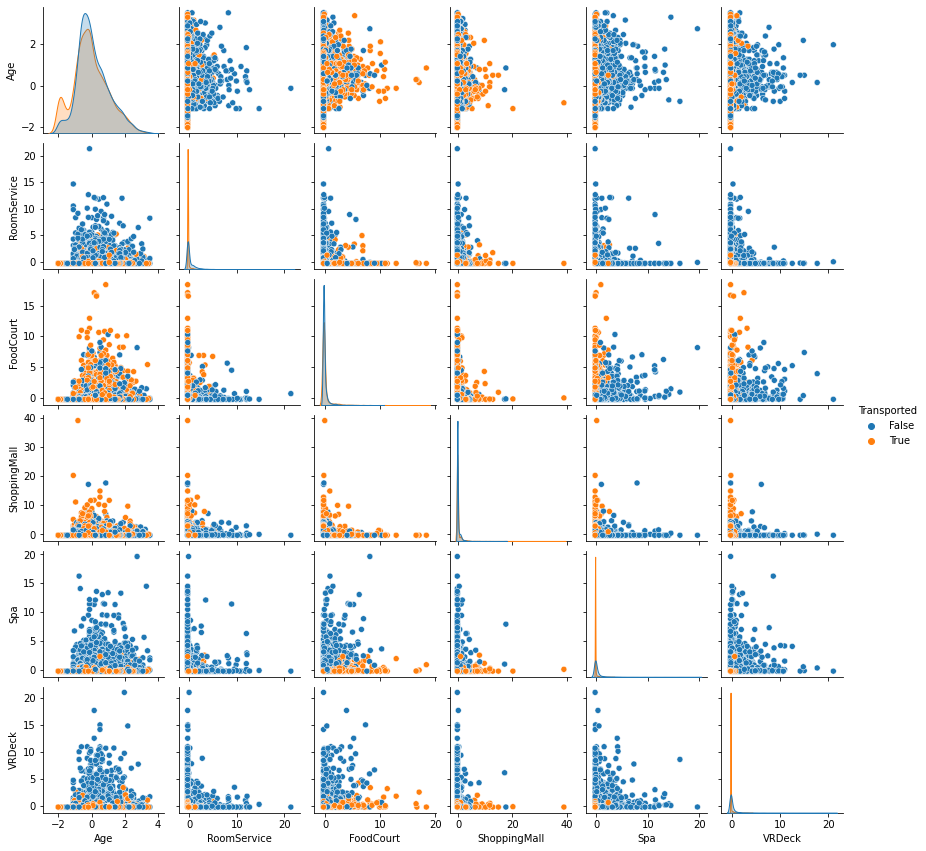

In [ ]:
#Create pair plots to analyze distributions and trends in predictors
plot_train = train
plot_train['Transported'] = labels_train
my_vars = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
fig_height = 2
sns.pairplot(plot_train, vars=my_vars, hue= "Transported", dropna=True,height=fig_height)

train = train.drop(['Transported'], axis=1)

## 2.3 Feature Selection and LDA

In this section, the modelling process for LDA models was started. This section includes two different LDA models.  The first is based off feature selection using an sklearn forward selection wrapper method while the second method uses a forward selection wrapper from the mlxtend package for feature selection before fitting the model.  The mlxtend package included selection of the best feature number as well as best feature selection, while a default value of 15 features was used for the sklearn method (half of the training features).  


### Feature Selection Using Sklearn Wrapper

In [ ]:
# Build classifier to use in feature selection 
lda = LinearDiscriminantAnalysis()

# Build step forward feature selection
model = sfs(lda,
           scoring='accuracy')

# Perform SFS
model = model.fit(train, labels_train)

In [ ]:
#set predictors for train and test sets and train final model
params = model.get_support(indices = True)
train1 = train.iloc[:,params]
feature_cols = train1.columns
print(f"The selected feature list contains {len(feature_cols)} columns including: {feature_cols}")
test1 = test.iloc[:,params]
model_fin = lda.fit(train1, labels_train)


The selected feature list contains 15 columns including: Index(['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'RoomService_ber', 'FoodCourt_ber', 'Spa_ber', 'VRDeck_ber',
       'HomePlanet_Europa', 'Destination_PSO J318.5-22', 'Deck_C', 'Deck_E',
       'Side_P'],
      dtype='object')


### Forward Feature Selection Using Mlxtend Wrapper

In [ ]:
#Feature Selection using alternate wrapper method
from mlxtend.feature_selection import SequentialFeatureSelector as ss

lda = LinearDiscriminantAnalysis()

fitter = ss(lda, k_features = "best", floating = False,
            forward=True, scoring='accuracy',
            cv=5)
fitted = fitter.fit(train,labels_train)

In [ ]:
#set predictors for train and test sets and train final model
params3 = fitted.k_feature_names_
param_list3 = []
for i in params3:
  param_list3.append(i)
train3 = train[param_list3]
feature_cols3 = train3.columns
print(f"The feature list selected contains {len(feature_cols3)} columns including: {feature_cols3}")
test3 = test[param_list3]
model_lda2 = lda.fit(train3, labels_train)

The feature list selected contains 26 columns including: Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'FamilyCounts', 'RoomService_ber', 'FoodCourt_ber',
       'ShoppingMall_ber', 'Spa_ber', 'VRDeck_ber', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A',
       'Deck_C', 'Deck_D', 'Deck_E', 'Deck_T', 'Side_P', 'Side_S'],
      dtype='object')


## 2.4 Feature Selection and QDA
As a comparison to LDA, quadratic discriminant analysis was applied using the same sklearn feature selection method as previousl mentioned.  This model resulted in less accurate predictions comapred to LDA with a kaggle score of 0.78138.

In [ ]:
#Sequential feature selection using a QDA model
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
# Build step forward feature selection
model2 = sfs(qda, 
           scoring='accuracy')


# Perform SFS
model2 = model2.fit(train, labels_train)

In [ ]:
#set predictors for train and test sets and train final model
params2 = model2.get_support(indices = True)
train2 = train.iloc[:,params2]
feature_cols2 = train2.columns
print(f"The feature list selected contains {len(feature_cols2)} columns including: {feature_cols2}")
test2 = test.iloc[:,params2]
model_qda = qda.fit(train2, labels_train)

The feature list selected contains 15 columns including: Index(['CryoSleep', 'Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'FamilyCounts',
       'RoomService_ber', 'FoodCourt_ber', 'VRDeck_ber', 'HomePlanet_Mars',
       'Destination_PSO J318.5-22', 'Deck_A', 'Deck_D', 'Deck_F', 'Side_P'],
      dtype='object')


## 2.5 Naive Bayes Classifier
The final model tested was a naive bayes classifier.  Feature selection for this method was completed using the forward slection method used in class and found an ideal feature number of 26 using cross validation. Using the entire kaggle training set and knowledge of the best number of features, a naive bayes model was trained to determine which 26 features to retain in the model.  

In [ ]:
#define functions to perform stepwise forward selection of variables
from sklearn.naive_bayes import GaussianNB as Gb
#split training and test data
x_train, x_test, y_train, y_test = train_test_split(train, labels_train, test_size = 0.15, random_state = 20)
def fit_subset(feature_set, x_train, y_train, x_test, y_test):
    # Fit model on feature_set and calculate accuracy
    model = Gb()
    mod = model.fit(x_train[list(feature_set)], y_train)
    accuracy = mod.score(x_test[list(feature_set)], y_test)
    return {'features':feature_set, 'model':mod, 'Accuracy': accuracy}

def forward(predictors, x_train, y_train, x_test, y_test):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in x_train.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(fit_subset(predictors+[p], x_train, y_train, x_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Accuracy'].argmax()]

    return best_model

In [ ]:
#deploy stepwise forward selection to identify ideal number of features for the model
models_train = pd.DataFrame(columns=['Accuracy', 'model'])

predictors = []

for i in range(1,len(train.columns)+1):    
    models_train.loc[i] = forward(predictors, x_train, y_train, x_test, y_test)
    predictors = list(models_train.loc[i]['model'].feature_names_in_)
    score = models_train.loc[i, "Accuracy"]
    print(f"model with {len(predictors)} predictors scored: {score}")
feat_len = len(list(models_train.loc[models_train['Accuracy'].argmax()]['model'].feature_names_in_))
print(f"The best model was that which contained {feat_len +1} features")


model with 1 predictors scored: 0.7078220858895705
model with 2 predictors scored: 0.7269938650306749
model with 3 predictors scored: 0.7354294478527608
model with 4 predictors scored: 0.7492331288343558
model with 5 predictors scored: 0.7668711656441718
model with 6 predictors scored: 0.7684049079754601
model with 7 predictors scored: 0.7714723926380368
model with 8 predictors scored: 0.7707055214723927
model with 9 predictors scored: 0.7707055214723927
model with 10 predictors scored: 0.7676380368098159
model with 11 predictors scored: 0.7615030674846626
model with 12 predictors scored: 0.7599693251533742
model with 13 predictors scored: 0.7668711656441718
model with 14 predictors scored: 0.7622699386503068
model with 15 predictors scored: 0.7730061349693251
model with 16 predictors scored: 0.7783742331288344
model with 17 predictors scored: 0.781441717791411
model with 18 predictors scored: 0.7799079754601227
model with 19 predictors scored: 0.7791411042944786
model with 20 predicto

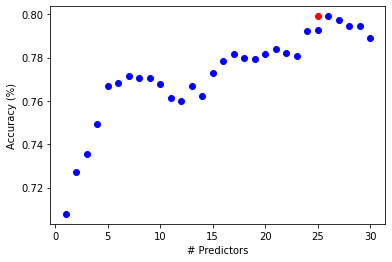

In [ ]:
#plot stepwise forward selection process
plt.plot(models_train['Accuracy'], "ob")
plt.xlabel('# Predictors')
plt.ylabel('Accuracy (%)')
plt.plot(models_train['Accuracy'].argmax(), models_train['Accuracy'].max(), 'or')
plt.show()

In [ ]:
#Train final model using full training dataset and ideal feature number
models_full = pd.DataFrame(columns=['Accuracy', 'model'])

predictors = []

for i in range(1,len(train.columns)+1):    
    models_full.loc[i] = forward(predictors, train, labels_train, train, labels_train)
    predictors = list(models_full.loc[i]['model'].feature_names_in_)

full_feat = sorted(models_full.loc[7, 'model'].feature_names_in_)


In [ ]:
#train final model
gnb = Gb()
train4 = train[full_feat]
nb_model = gnb.fit(train4, labels_train)
test4 = test[full_feat]

## 2.6 Feature Selection and Logistic Regression

### Forward Feature Selection using Sklearn Wrapper

In [ ]:
#Feature Selection using sklearn forward selection
LR = LogisticRegression()

feat_select =sfs(LR, direction='forward',
            scoring='accuracy',
            cv=5 )

fit = feat_select.fit(train,labels_train)



In [ ]:
#set predictors for train and test sets and train final model
params5 = fit.feature_names_in_
param_list5 = []
for i in params5:
  param_list5.append(i)
train5 = train[param_list5]
feature_cols5 = train5.columns
print(f"The feature list selected contains {len(feature_cols5)} columns including: {feature_cols5}")
test5 = test[param_list5]
model_LR = LR.fit(train5, labels_train)

The feature list selected contains 30 columns including: Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'FamilyCounts', 'RoomService_ber', 'FoodCourt_ber',
       'ShoppingMall_ber', 'Spa_ber', 'VRDeck_ber', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Side_P', 'Side_S'],
      dtype='object')


### Forward Feature Selection Using Mlxtend Wrapper

In [ ]:
#Feature Selection using mlxtend wrapper
fitter1 = ss(LR, k_features = "best",  forward=True, floating = False, 
             scoring='accuracy',cv=5)
fitted1 = fitter1.fit(train,labels_train)


In [ ]:
#set predictors for train and test sets and train final model
params6 = fitted1.k_feature_names_
param_list6 = []
for i in params6:
  param_list6.append(i)
train6 = train[param_list6]
feature_cols6 = train6.columns
print(f"The feature list selected contains {len(feature_cols6)} columns including: {feature_cols6}")
test6 = test[param_list6]
model_LR1 = LR.fit(train6, labels_train)

The feature list selected contains 13 columns including: Index(['CryoSleep', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'RoomService_ber', 'ShoppingMall_ber', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E'],
      dtype='object')


# 3 Final Model Predictions and Evaluation
Each of the four models discussed above was evaluated on the held-out kaggle dataset.  Overall, the logistic regression model with 13 features was found to perform best with an accuracy score of 0.79611.

In [ ]:
#Model using Logistic Regression and feature selection using sklearn 
test5['preds'] = model_LR.predict(test5)
submissiondf = pd.DataFrame({'PassengerId': id, 'Transported': test5['preds']})
submissiondf.to_csv('submissiondf_LR.csv', index = False)

#Model using Logistic Regression and feature selection using mltxtend
test6['preds'] = model_LR1.predict(test6)
submissiondf = pd.DataFrame({'PassengerId': id, 'Transported': test6['preds']})
submissiondf.to_csv('submissiondf_LR1.csv', index = False)

In [ ]:
#predict housing prices for kaggle submission
#Model using LDA and sklearn feature selection wrapper
test1['preds'] = model_fin.predict(test1)
submissiondf = pd.DataFrame({'PassengerId': id, 'Transported': test1['preds']})
submissiondf.to_csv('submissiondf_lda.csv', index = False)

#Model using QDA and feature selection using sklearn feture selection wrapper 
test2['preds'] = model_qda.predict(test2)
submissiondf = pd.DataFrame({'PassengerId': id, 'Transported': test2['preds']})
submissiondf.to_csv('submissiondf_QDA.csv', index = False)

#Model using LDA and mlxtend feature selection wrapper
test3['preds'] = model_lda2.predict(test3)
submissiondf = pd.DataFrame({'PassengerId': id, 'Transported': test3['preds']})
submissiondf.to_csv('submissiondf_lda2.csv', index = False)

#Model using Naive Bayes and feature selection method from class 
test4['preds'] = nb_model.predict(test4)
submissiondf = pd.DataFrame({'PassengerId': id, 'Transported': test4['preds']})
submissiondf.to_csv('submissiondf_NB2.csv', index = False)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#Model coefficient interpretation and understanding
#coefficients of best LDA model
feats_LDA = ['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'RoomService_ber', 'FoodCourt_ber', 'Spa_ber', 'VRDeck_ber',
       'HomePlanet_Europa', 'Destination_PSO J318.5-22', 'Deck_C', 'Deck_E',
       'Side_P']
param_LDA = [1.61375423, -0.36648782 , 0.47592158 , 0.34037282 ,-0.53032304 ,
             -0.5114489, -0.51982301 , 0.08590419, -0.70124195 ,-0.75236845,  1.22366814 ,-0.19074106,
   0.44741482 ,-0.37337432, -0.52115889]

params_df = pd.DataFrame({'features':feats_LDA, 'coefs': param_LDA })
print("LDA Coefficient results\n", params_df)

#Coefficients of best LR model
param_LR = [ 1.13078834, -0.05570051, -0.73869171,  0.8876556,   0.47140962, -2.09616658,
  -2.05312445, -0.33875898, -0.3681047 ,  1.92152356 , 2.74747157 , 0.66609567,
  -0.1652091]
feats_LR = ['CryoSleep', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'RoomService_ber', 'ShoppingMall_ber', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E']

params_df2 = pd.DataFrame({'features':feats_LR, 'coefs': param_LR })
print("LR Coefficient results \n", params_df2)


LDA Coefficient results
                      features     coefs
0                   CryoSleep  1.613754
1                 RoomService -0.366488
2                   FoodCourt  0.475922
3                ShoppingMall  0.340373
4                         Spa -0.530323
5                      VRDeck -0.511449
6             RoomService_ber -0.519823
7               FoodCourt_ber  0.085904
8                     Spa_ber -0.701242
9                  VRDeck_ber -0.752368
10          HomePlanet_Europa  1.223668
11  Destination_PSO J318.5-22 -0.190741
12                     Deck_C  0.447415
13                     Deck_E -0.373374
14                     Side_P -0.521159
LR Coefficient results 
             features     coefs
0          CryoSleep  1.130788
1                Age -0.055701
2        RoomService -0.738692
3          FoodCourt  0.887656
4       ShoppingMall  0.471410
5                Spa -2.096167
6             VRDeck -2.053124
7    RoomService_ber -0.338759
8   ShoppingMall_ber -0.368105


# 4 Ethical Analysis
While this dataset is artificially generated, it remains important to highlight potential ethical issues that could arise from our analysis and modelling. The first ethical issue that arises is the handling of NA values. Nearly all columns of the dataset contained NA values that were handled using various imputation methods.  While these handling methods help, they do not truly make up for the missing data and the reasons for such NA values are largely unknown. For this reason, methods for handling NA's inherently introduce bias into the model that alter how the model predicts future classes. 

 Additionally, the overall goal of this challenge has ethical issues, although this is an artificial dataset, if this problem or a similar one were to exist, using a machine learning algorithm to decide who must be saved is unethical. 
 
 The model will never be perfect and for that reason, some individuals that were transported to the alternate dimension will be missed and therefore not saved.  Machine learning solutions to the problem at hand will have significant ethical consequences as it essentially decides who will live and die.
 
  Furthermore, this dataset contained passenger names of those on the ship.  While this data is artifical, in real-world situations, data must be anonomized to preserve the security and privacy of individuals on the ship.  For this reason, the Name column was dropped from the data at the beginning of the analysis process.
  
   Also, ethical issues arise due to interpretability of the model.  As models used in this challenge contain many predictors, interpretation of the model becomes very difficult meaning use of the model without proper understanding could lead to inaccacurate evaluations of the most important features in determining the transportation status of an individual. 
   
   Finally, the model deployed above uses a range of predictors related to the individuals on-board but contains no information related to the outside environment.  Characteristics of the environment may interact with characteristics of an individual to influence whther or not they are transported.  For this reason, lack of environment-level characteristics introduces bias to the model.  

# 5 Interpretations

While six final models with kaggle submissions were produced, only the results from the best discriminant analysis model and the best LR model will be interpretted. Overall, both the LDA and the LR models performed well on the held out kaggle test set with accuracy scores of 0.796 and 0.788 respectively. With respect to the logistic regression model, 13 features were selected for inclusion in the model, including 'CryoSleep', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'RoomService_ber', 'ShoppingMall_ber', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E'.

 Continuous variables included in the model such as age (coef -0.0557) and room service (coef -0.7387) can be compared one-to-one for their contribution to the model due to standardization of these variables earlier in the cleaning process. This means it can be said that a unit increase in room service expenditure results in a greater reduction in likelihood of being transported compared to a unit increase in age. 
 
 For ordinal and dummy variables, similar comparisons cannot be made. For dummy variables such as those for 'side', interpretations can be made based on levels of the variable vs. the reference level.  For example, when all other characteristics are the same for two individuals, it can be said that an individual that spent money on room service is less likely to be transported compared to an individual that did not spend money on room service, by a factor of -0.337. Overall, the most important features in the best logistic regression model were found to be Spa (coef -2.096), VR_deck (coef -2.053) and residence on deck C (coef 2.747). Comparatively, the features with the greatest impact in the LDA model included cryosleep status (coef 1.614) and a home planet of Europa (coef 1.224). The LDA model differed from the logistic regresion model significantly with respect to features retained in the model.  The LDA model kept all bernoulli variables indicating money spent on amenities while placing reduced predictive weight on all amenities-related features in the model compared to logistic regression.  As well, the LDA model kept fewer deck-related variables in the model.  
 
 Beyond interpretation of individual model parameters, it can be said that both LDA and LR are effective methods for classifying the dataset as accuracy of both models exceeded 75%. Despite this, the data lends itself better to the logistic regression models.  This likely results from violation of assumptions necessary for the LDA model. LR does not require the same assumptions of variable distribution which could explain its improved performance in this challenge.      

# 6 References
Sequential Feature Selection: 
https://www.kdnuggets.com/2018/06/step-forward-feature-selection-python.html

Handling missing values: https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e

Mlxtend documentation
http://rasbt.github.io/mlxtend/

Stackoverflow questions
https://stackoverflow.com/